# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


#### Solution

We will load the PCAP using netml.

In [1]:
from netml.pparser.parser import PCAP

pcap_file = "data/netflix.pcap"

pcap = PCAP(pcap_file=pcap_file, verbose=1)

### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

#### Solution
First, we will load the prepocessed CSV of the packet trace (likely created using the Wireshark GUI).

We will use the CSV from the course GitHub that we used for the in-class assignments.

In [2]:
import pandas as pd
import numpy as np

# Import the CSV file of the packet trace into a DataFrame
# Note: You must preprocess netflix.pcap into a CSV file (likely using the Wireshark GUI)
# These results use the CSV file from the course GitHub
csv_path = "data/netflix.csv.gz"
packet_trace_df = pd.read_csv(csv_path)
packet_trace_df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,2018-02-11 08:10:00.534682,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,77,Standard query 0xed0c A fonts.gstatic.com
1,2,2018-02-11 08:10:00.534832,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,77,Standard query 0x301a AAAA fonts.gstatic.com
2,3,2018-02-11 08:10:00.539408,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,87,Standard query 0x11d3 A googleads.g.doubleclic...
3,4,2018-02-11 08:10:00.541204,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,87,Standard query 0x1284 AAAA googleads.g.doublec...
4,5,2018-02-11 08:10:00.545785,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,78,Standard query 0x3432 AAAA ytimg.l.google.com
5,6,2018-02-11 08:10:00.547036,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,96,Standard query 0xb756 A r4---sn-gxo5uxg-jqbe.g...
6,7,2018-02-11 08:10:00.547156,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,75,Standard query 0x62ab A ssl.gstatic.com
7,8,2018-02-11 08:10:00.547249,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,74,Standard query 0x42fb A www.google.com
8,9,2018-02-11 08:10:00.853950,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,386,Standard query response 0x11d3 A 216.58.213.162
9,10,2018-02-11 08:10:00.853970,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,75,Standard query 0x8756 A www.gstatic.com


Next, we will use the DNS information to find the Netflix IP addresses.

To do so, we will first filter for DNS requests for Netflix domains. Then, we
will use the transaction IDs from those requests to find the responses to those
requests. The IP addresses associated with those responses will be the Netflix IP
addresses we need!

In [3]:
import re

# Filter the dataframe for only DNS traffic
dns_df = packet_trace_df[packet_trace_df['Protocol'] == 'DNS'].copy()

# Extract the transaction IDs from the Info column
transaction_id_pattern = r'(0x[0-9a-fA-F]+)'
dns_df['TransactionID'] = dns_df['Info'].str.extract(transaction_id_pattern)
dns_df.dropna(subset=['TransactionID'], inplace=True)
dns_df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,TransactionID
0,1,2018-02-11 08:10:00.534682,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,77,Standard query 0xed0c A fonts.gstatic.com,0xed0c
1,2,2018-02-11 08:10:00.534832,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,77,Standard query 0x301a AAAA fonts.gstatic.com,0x301a
2,3,2018-02-11 08:10:00.539408,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,87,Standard query 0x11d3 A googleads.g.doubleclic...,0x11d3
3,4,2018-02-11 08:10:00.541204,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,87,Standard query 0x1284 AAAA googleads.g.doublec...,0x1284
4,5,2018-02-11 08:10:00.545785,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,78,Standard query 0x3432 AAAA ytimg.l.google.com,0x3432
5,6,2018-02-11 08:10:00.547036,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,96,Standard query 0xb756 A r4---sn-gxo5uxg-jqbe.g...,0xb756
6,7,2018-02-11 08:10:00.547156,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,75,Standard query 0x62ab A ssl.gstatic.com,0x62ab
7,8,2018-02-11 08:10:00.547249,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,74,Standard query 0x42fb A www.google.com,0x42fb
8,9,2018-02-11 08:10:00.853950,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,386,Standard query response 0x11d3 A 216.58.213.162,0x11d3
9,10,2018-02-11 08:10:00.853970,192.168.43.72,ns-vip-pro.paris.inria.fr,DNS,75,Standard query 0x8756 A www.gstatic.com,0x8756


In [4]:
# Filter only for Netflix-related DNS queries
netflix_domains_pattern = 'nflxvideo|netflix|nflxso|nflxext' # All the Netflix domains, taken from notebook 3
is_netflix_domain = dns_df['Info'].str.contains(netflix_domains_pattern, case=False, na=False)
is_query = ~dns_df['Info'].str.contains('response', case=False, na=False)
netflix_query_ids = set(dns_df[is_netflix_domain & is_query]['TransactionID'])

print("Netflix Transaction IDs:")
for query_id in netflix_query_ids:
    print(query_id)

Netflix Transaction IDs:
0x3981
0x9415
0xa9b1
0x86ee
0x6677
0x3049
0x269f
0x80e9
0x1f03
0xb19a
0xed3f
0x5542
0x82dc
0x5f60
0x37e9
0x7776
0xc0b4


In [5]:
# Find the response packets that match the Netflix query IDs
is_response = dns_df['Info'].str.contains('response', case=False, na=False)
matches_netflix_query = dns_df['TransactionID'].isin(netflix_query_ids)
netflix_response_df = dns_df[is_response & matches_netflix_query]

netflix_response_df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,TransactionID
101,102,2018-02-11 08:10:02.902769,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,539,Standard query response 0x7776 A 198.38.120.130,0x7776
102,103,2018-02-11 08:10:02.902776,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,545,Standard query response 0xb19a A 52.19.39.146,0xb19a
103,104,2018-02-11 08:10:02.902810,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,534,Standard query response 0x1f03 A 52.210.19.176,0x1f03
104,105,2018-02-11 08:10:02.902831,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,539,Standard query response 0x37e9 A 198.38.120.153,0x37e9
105,106,2018-02-11 08:10:02.902858,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,494,Standard query response 0x3049 A 23.57.80.120,0x3049
108,109,2018-02-11 08:10:02.903312,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,514,Standard query response 0x5f60 A 23.57.80.120,0x5f60
219,220,2018-02-11 08:10:03.642910,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,239,Standard query response 0x6677 A 198.38.120.137,0x6677
228,229,2018-02-11 08:10:03.670254,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,539,Standard query response 0x9415 A 198.38.120.167,0x9415
1019,1020,2018-02-11 08:10:12.323453,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,547,Standard query response 0x5542 A 34.252.77.54,0x5542
1566,1567,2018-02-11 08:10:20.775688,ns-vip-pro.paris.inria.fr,192.168.43.72,DNS,539,Standard query response 0x269f A 198.38.120.134,0x269f


In [6]:
# Extract all IP addresses from the Info column of the response packets
ip_pattern = re.compile(
    r'\b((?:[0-9]{1,3}\.){3}[0-9]{1,3})|([0-9a-fA-F:.]*:[0-9a-fA-F]{1,4})\b'
)
netflix_ips = set()
for info in netflix_response_df['Info']:
    found_ips = ip_pattern.findall(info)
    for ipv4, ipv6 in found_ips:
        if ipv4:
            netflix_ips.add(ipv4)
        if ipv6:
            # Basic cleaning for IPv6 matches that might be part of other text
            cleaned_ipv6 = ipv6.split(' ')[-1]
            netflix_ips.add(cleaned_ipv6)

print("Extracted Netflix IPs:")
for ip in netflix_ips:
    print(ip)

Extracted Netflix IPs:
198.38.120.164
198.38.120.130
198.38.120.137
198.38.120.134
52.208.128.101
198.38.120.166
34.252.77.54
198.38.120.153
52.48.148.78
52.210.133.255
198.38.120.167
52.210.19.176
23.57.80.120
198.38.120.162
52.19.39.146
52.48.8.150


Lastly, we will extract flows from the loaded PCAP file with netml and filter those flows for those involving Netflix IPs.

In [7]:
# Extract flows from the unfiltered PCAP using netml
pcap.pcap2flows()
print(f"Found {len(pcap.flows)} total flows before filtering.")

# Filter the flows to only include those with source IPs in the Netflix IP set
# We check only source IPs since we are trying to monitor video streaming, and
# video streaming requires loading data from Netflix servers to the client.
filtered_flows = []
for flow in pcap.flows:
    fid, packets = flow
    if fid[0] in netflix_ips:
        filtered_flows.append(flow)
pcap.flows = filtered_flows
print(f"Filtered down to {len(pcap.flows)} Netflix-related flows.")


pcap_file: data/netflix.pcap
Found 184 total flows before filtering.
Filtered down to 69 Netflix-related flows.


### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [8]:
pcap.flow2features('STATS', fft=False, header=False)

# Define column names for the STATS features based on the library's implementation
stats_columns = [
    'duration',       # Duration of the flow in seconds
    'pkts_rate',      # Packets per second
    'bytes_rate',     # Bytes per second
    'mean_pkt_size',  # Mean size of packets in the flow
    'std_pkt_size',   # Standard deviation of packet sizes
    'q1_pkt_size',    # 1st quartile of packet sizes
    'median_pkt_size',# Median (2nd quartile) of packet sizes
    'q3_pkt_size',    # 3rd quartile of packet sizes
    'min_pkt_size',   # Minimum packet size
    'max_pkt_size',   # Maximum packet size
    'num_pkts',       # Total number of packets in the flow
    'num_bytes'       # Total number of bytes in the flow
]
stats_df = pd.DataFrame(pcap.features, columns=stats_columns)

desired_columns = [
    'duration',
    'num_bytes',
    'bytes_rate',
    'mean_pkt_size',
    'max_pkt_size',
    'std_pkt_size'
]
features_df = stats_df[desired_columns].copy()
features_df.head(20)

,duration,num_bytes,bytes_rate,mean_pkt_size,max_pkt_size,std_pkt_size
0,13.724249,1383.0,100.770542,138.300000,200.0,62.925432
1,13.725949,1383.0,100.758060,138.300000,200.0,62.925432
2,13.727318,1183.0,86.178525,131.444444,200.0,62.686364
3,13.728545,1383.0,100.739006,138.300000,200.0,62.925432
4,13.732716,1383.0,100.708410,138.300000,200.0,62.925432
5,13.741529,1383.0,100.643822,138.300000,200.0,62.925432
6,13.742754,1583.0,115.187975,143.909091,200.0,62.564083
7,13.742588,1583.0,115.189366,143.909091,200.0,62.564083
8,13.743621,1583.0,115.180709,143.909091,200.0,62.564083
9,13.703466,1429.0,104.280188,129.909091,200.0,58.689405


**Write a brief justification for the features that you have chosen.**

I chose to analyze STATS features, as they already provide some key analysis of the network data from the flow.

Among all the different statistics given, I chose to only use the following features for the following reasons: 
- Duration: The length of the flow, necessary to contextualize the other properties.
- Num Bytes: The total amount of data transferred. Higher amounts of data transfer likely indicate higher resolution video (likely loosely coorelates with video bitrate).
- Bytes-Rate (bytes per second): Monitors how much data was loaded on average in a given time interval. More information loaded in a short time could indicate higher resolution video.
- Mean packet size: Tells the average amount of data sent in each packet. More data per packet likely indicates higher resolution video.
- Max packet size: Tells the maximum amount of data sent out of all packets. When sending higher resolution videos, packets will likely need to be larger in general, so the maximum size of packets will likely be larger to reflect this.
- Standard Deviation of packet size: Monitors how volatile the packet sizes are. More volatile packet sizes could indicate changing video resolutions and a non-smooth playback experience.

Here are the STATS features I did not choose and why:
- Num Packets and Packets-Rate: We are about the amount of data transferred (since higher resolution videos require more data), not packets transferred, so it is more productive to monitor info about bytes than packets.
- Min packet size: The minimum packet size likely isn't meaningful as the max and mean packet sizes are already the best packet size indications of video resolutions, and if there are any other types of data transfer from Netflix that do not contain video data, they will likely contain less data, so they would override the min packet size and make it irrelevant. 
- Q1, Median, Q3 packet size: This information is already represented well with the mean and standard deviation features we already have. Including these extras is redundant.

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

#### Solution
I will use the IAT features to extract the video samples, since IAT features give time windows between samples. I strongly suspect the recommendation for using SAMP style options is a mistake, as those options do not give you time windows.

In my understanding, segments are large bursts of video data sent to the client from the streaming service all at once. We can detect when a segment ends and a new one begins by seeing when there is a large time interval between packets recieved. Thus, if we count the number of gaps above some threshold in a given time interval, then the segment download rate for that time interval is `(num_gaps + 1) / time_interval`.

In [9]:
# Extract IAT features
pcap.flow2features('IAT', fft=False, header=False)
iat_features = pcap.features

# Count the number of gaps above some idle threshold in each flow's IAT features
# and use this to compute segment download rates
idle_threshold = 1
segment_counts = []
for iat_sequence in iat_features:
    iats = np.array(iat_sequence)
    num_gaps = sum(iats > idle_threshold)
    num_segments = num_gaps + 1
    segment_counts.append(num_segments)

# Add the segment download rates to the features DataFrame
features_df['segment_download_rate'] = segment_counts / stats_df['duration']
features_df.head(20)

,duration,num_bytes,bytes_rate,mean_pkt_size,max_pkt_size,std_pkt_size,segment_download_rate
0,13.724249,1383.0,100.770542,138.300000,200.0,62.925432,0.364319
1,13.725949,1383.0,100.758060,138.300000,200.0,62.925432,0.364274
2,13.727318,1183.0,86.178525,131.444444,200.0,62.686364,0.291390
3,13.728545,1383.0,100.739006,138.300000,200.0,62.925432,0.291364
4,13.732716,1383.0,100.708410,138.300000,200.0,62.925432,0.291275
5,13.741529,1383.0,100.643822,138.300000,200.0,62.925432,0.291088
6,13.742754,1583.0,115.187975,143.909091,200.0,62.564083,0.291062
7,13.742588,1583.0,115.189366,143.909091,200.0,62.564083,0.291066
8,13.743621,1583.0,115.180709,143.909091,200.0,62.564083,0.291044
9,13.703466,1429.0,104.280188,129.909091,200.0,58.689405,0.291897


## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [10]:
netflix_df = pd.read_pickle('data/netflix_dataset.pkl')

print("num netflix_df columns:", len(netflix_df.columns))
netflix_df.head(20)


num netflix_df columns: 251


,10_EWMA_chunksizes,10_avg_chunksize,10_chunksizes_50,10_chunksizes_50R,10_chunksizes_75,10_chunksizes_75R,10_chunksizes_85,10_chunksizes_85R,10_chunksizes_90,10_chunksizes_90R,...,userTwoRetransmit,userUrgFlags,userXRetransmit,userZeroRetransmit,service,startup3.3,startup6.6,startup5,startup10,startup_mc
208,"[[4380.0], [4380.0], [19682.095238095237], [23...",148947.1,43473.0,43473.0,185098.0,185098.0,361832.3,361832.3,461040.2,461040.2,...,0.0,0,0.108730,0.557937,netflix,False,False,False,False,12.0
209,"[[179260.0], [130204.0], [49666.09523809524], ...",91984.2,101882.0,101882.0,122323.0,122323.0,159843.4,159843.4,181011.8,181011.8,...,0.0,0,0.116865,0.549802,netflix,False,False,False,False,12.0
210,"[[317962.0], [83192.4], [170850.7619047619], [...",147725.0,111373.0,111373.0,224157.0,224157.0,286280.0,286280.0,325845.8,325845.8,...,0.0,0,0.126852,0.539815,netflix,False,False,False,False,12.0
211,"[[396800.0], [98961.6], [246910.09523809524], ...",246420.6,297522.0,297522.0,330737.5,330737.5,361030.7,361030.7,378404.0,378404.0,...,0.0,0,0.186111,0.480556,netflix,False,False,False,False,12.0
212,"[[325264.0], [331102.4], [365584.38095238095],...",336681.0,354461.0,354461.0,399719.5,399719.5,409866.3,409866.3,414060.0,414060.0,...,0.0,0,0.194444,0.472222,netflix,False,False,False,False,12.0
213,"[[411400.0], [240875.2], [256226.66666666666],...",316355.2,324531.0,324531.0,374899.5,374899.5,399647.0,399647.0,412422.2,412422.2,...,0.0,0,0.222222,0.444444,netflix,False,False,False,False,12.0
214,"[[366138.0], [299565.2], [220140.2857142857], ...",381471.4,350079.0,350079.0,490608.5,490608.5,545866.1,545866.1,569370.6,569370.6,...,0.0,0,0.333333,0.444444,netflix,False,False,False,False,12.0
215,"[[198244.0], [487900.0], [713274.4761904762], ...",488343.0,526009.0,526009.0,601931.0,601931.0,689530.0,689530.0,740338.4,740338.4,...,0.0,0,0.208333,0.625000,netflix,False,False,False,False,12.0
216,"[[198242.0], [371104.4], [548640.0952380953], ...",503673.8,599742.0,599742.0,620545.0,620545.0,633539.0,633539.0,641204.4,641204.4,...,0.0,0,0.305556,0.361111,netflix,False,False,False,False,12.0
217,"[[595364.0], [512436.0], [273051.61904761905],...",565869.8,615072.0,615072.0,635145.0,635145.0,652448.6,652448.6,695958.2,695958.2,...,0.0,0,0.416667,0.416667,netflix,False,False,False,False,12.0


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

In [11]:
print(f"Number of rows before filtering: {len(netflix_df)}")

valid_resolutions = [240, 360, 480, 720, 1080]
netflix_df = netflix_df[netflix_df['resolution'].isin(valid_resolutions)].copy()

print(f"Number of rows after filtering: {len(netflix_df)}")

Number of rows before filtering: 52279
Number of rows after filtering: 49748


2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

In [12]:
# Remove columns with non-numeric data
numeric_df = netflix_df.select_dtypes(include=np.number)
print("num numeric_df columns:", len(numeric_df.columns))

num numeric_df columns: 238


In [13]:
non_nan_df = numeric_df.dropna(axis=1)
print("num non_nan_df columns:", len(non_nan_df.columns))

num non_nan_df columns: 237


In [14]:
# Remove columns with the same value in every row
unique_df = non_nan_df.loc[:, non_nan_df.nunique(dropna=False) > 1]
print("num unique_df columns:", len(unique_df.columns))
', '.join(unique_df.columns)

num unique_df columns: 225


'10_avg_chunksize, 10_chunksizes_50, 10_chunksizes_50R, 10_chunksizes_75, 10_chunksizes_75R, 10_chunksizes_85, 10_chunksizes_85R, 10_chunksizes_90, 10_chunksizes_90R, 10_max_chunksize, 10_min_chunksize, 10_std_chunksize, absolute_timestamp, access_50_perc, access_75_perc, access_avg, access_max, access_min, access_stddev, access_var, all_prev_down_chunk_iat_50, all_prev_down_chunk_iat_50R, all_prev_down_chunk_iat_75, all_prev_down_chunk_iat_75R, all_prev_down_chunk_iat_85, all_prev_down_chunk_iat_85R, all_prev_down_chunk_iat_90, all_prev_down_chunk_iat_90R, all_prev_down_chunk_iat_avg, all_prev_down_chunk_iat_max, all_prev_down_chunk_iat_min, all_prev_down_chunk_iat_std, all_prev_up_chunk_iat_50, all_prev_up_chunk_iat_50R, all_prev_up_chunk_iat_75, all_prev_up_chunk_iat_75R, all_prev_up_chunk_iat_85, all_prev_up_chunk_iat_85R, all_prev_up_chunk_iat_90, all_prev_up_chunk_iat_90R, all_prev_up_chunk_iat_avg, all_prev_up_chunk_iat_max, all_prev_up_chunk_iat_min, all_prev_up_chunk_iat_std, 

In [15]:
columns_to_drop = [
    # Unclear what the column means
    '10_chunksizes_50R',
    '10_chunksizes_75R',
    '10_chunksizes_85R',
    '10_chunksizes_90R',
    '10_avg_chunksize',
    '10_chunksizes_50',
    '10_chunksizes_75',
    '10_chunksizes_85',
    '10_chunksizes_90',
    '10_max_chunksize',
    '10_min_chunksize',
    '10_std_chunksize',
    'access_50_perc',
    'access_75_perc',
    'access_avg',
    'access_max',
    'access_min',
    'access_stddev',
    'access_var',
    'all_prev_down_chunk_iat_50R',
    'all_prev_down_chunk_iat_75R',
    'all_prev_down_chunk_iat_85R',
    'all_prev_down_chunk_iat_90R',
    'all_prev_up_chunk_iat_50R',
    'all_prev_up_chunk_iat_75R',
    'all_prev_up_chunk_iat_85R',
    'all_prev_up_chunk_iat_90R',
    'allprev_chunksizes_50R',
    'allprev_chunksizes_75R',
    'allprev_chunksizes_85R',
    'allprev_chunksizes_90R',
    'cumsum_diff',
    'down_chunk_iat_50R',
    'down_chunk_iat_75R',
    'down_chunk_iat_85R',
    'down_chunk_iat_90R',
    'serverEndBytesPerPacket',
    'serverKurBytesInFlight',
    'serverKurBytesPerPacket',
    'serverKurInterArrivalTime',
    'serverKurRetransmit',
    'serverKurRwnd',
    'serverSkeBytesInFlight',
    'serverSkeBytesPerPacket',
    'serverSkeInterArrivalTime',
    'serverSkeRetransmit',
    'serverSkeRwnd',
    'serverStrBytesPerPacket',
    'startup_mc',
    'up_chunk_iat_50R',
    'up_chunk_iat_75R',
    'up_chunk_iat_85R',
    'up_chunk_iat_90R',
    'userEndBytesInFlight',
    'userKurBytesInFlight',
    'userKurBytesPerPacket',
    'userKurInterArrivalTime',
    'userKurRTT',
    'userKurRetransmit',
    'userKurRwnd',
    'userSkeBytesInFlight',
    'userSkeBytesPerPacket',
    'userSkeInterArrivalTime',
    'userSkeRTT',
    'userSkeRetransmit',
    'userSkeRwnd',
    'userStrBytesInFlight',
    'wireless_50_perc',
    'wireless_75_perc',
    'wireless_avg',
    'wireless_max',
    'wireless_min',
    'wireless_stddev',
    'wireless_var',

    # Harmful
    'c_resolution_switches',
    'c_bitrate_switches',
    'n_bitrate_switches',

    # Irrelevant
    'all_prev_up_chunk_iat_50',
    'all_prev_up_chunk_iat_75',
    'all_prev_up_chunk_iat_85',
    'all_prev_up_chunk_iat_90',
    'all_prev_up_chunk_iat_avg',
    'all_prev_up_chunk_iat_max',
    'all_prev_up_chunk_iat_min',
    'all_prev_up_chunk_iat_std',
    'n_chunks_up',
    'n_prev_up_chunk',
    'service_Video_throughput_up',
    'service_non_video_throughput_down',
    'service_non_video_throughput_up',
    'total_throughput_up',
    'up_chunk_iat_50',
    'up_chunk_iat_75',
    'up_chunk_iat_85',
    'up_chunk_iat_90',
    'up_chunk_iat_avg',
    'up_chunk_iat_max',
    'up_chunk_iat_min',
    'up_chunk_iat_std',
    'up_down_ratio',
    'serverAckFlags',
    'serverBitrateChange',
    'serverFinFlags',
    'serverPshFlags',
    'serverSynFlags',
    'userAckFlags',
    'userFinFlags',
    'userPshFlags',
    'userSynFlags',
    # We will also remove 'absolute_timestamp' later
]

filtered_df = unique_df.drop(columns=columns_to_drop)

print("num filtered_df columns:", len(filtered_df.columns))
filtered_df.head(20)

num filtered_df columns: 116


,absolute_timestamp,all_prev_down_chunk_iat_50,all_prev_down_chunk_iat_75,all_prev_down_chunk_iat_85,all_prev_down_chunk_iat_90,all_prev_down_chunk_iat_avg,all_prev_down_chunk_iat_max,all_prev_down_chunk_iat_min,all_prev_down_chunk_iat_std,allprev_avg_chunksize,...,userRstFlags,userStdBytesInFlight,userStdBytesPerPacket,userStdInterArrivalTime,userStdRTT,userStdRetransmit,userStdRwnd,userTwoRetransmit,userXRetransmit,userZeroRetransmit
208,1.548881e+09,161.5,602.50,2256.65,3144.3,808.400000,3318,34,1223.070987,135804.636364,...,0,330.414175,94.051096,287.440770,19684.624818,57.462837,985.136457,0.0,0.108730,0.557937
209,1.548881e+09,361.0,614.00,768.75,938.1,588.666667,3318,19,786.055610,116377.193548,...,0,361.139739,119.846893,258.309037,8183.942278,71.011784,310.123152,0.0,0.116865,0.549802
210,1.548881e+09,337.0,620.00,834.40,1517.6,574.836735,3318,19,705.095227,122928.060000,...,0,361.942841,111.889532,228.912856,7087.849223,85.198800,149.669427,0.0,0.126852,0.539815
211,1.548881e+09,399.0,652.00,1215.00,1773.6,658.894737,3318,19,762.726864,141194.948276,...,0,363.797811,79.787976,239.768490,56963.445789,109.397055,14006.713648,0.0,0.186111,0.480556
212,1.548881e+09,414.0,782.25,1561.60,1859.7,744.483871,3435,19,832.286217,159076.079365,...,0,377.300424,65.877408,1789.026714,10988.579443,122.132897,13261.305817,0.0,0.194444,0.472222
213,1.548881e+09,455.5,842.00,1680.00,2020.1,791.614286,3435,19,838.425690,177122.549296,...,0,378.002645,72.078993,691.809915,8144.039377,124.199353,13082.888176,0.0,0.222222,0.444444
214,1.548881e+09,504.5,985.25,1740.70,2020.7,846.608108,4561,19,930.026515,193004.680000,...,1,376.408761,50.499795,572.636645,9950.113076,124.497801,10468.894116,0.0,0.333333,0.444444
215,1.548881e+09,543.0,1334.50,1801.80,2141.0,937.963855,6207,19,1088.642411,228101.630952,...,0,378.837439,67.826168,1379.288878,9869.594000,137.549323,22606.505896,0.0,0.208333,0.625000
216,1.548881e+09,561.0,1507.25,1861.35,2549.7,994.261364,6207,19,1126.949861,245994.662921,...,0,378.803590,51.595632,264.538296,7828.062843,150.970768,23901.900442,0.0,0.305556,0.361111
217,1.548881e+09,596.0,1527.50,1941.50,2541.0,1018.000000,6207,19,1122.535582,257958.336957,...,1,375.607589,44.724232,506.193985,1730.533668,134.311413,23728.206979,0.0,0.416667,0.416667


**Briefly explain why you removed those columns.**

First, I removed all columns containing non-numeric data or NaNs as we cannot use that for optimization.

Next, I removed all columns that provided no useful information (i.e. columns where there is the same value in every column). 

After this, I manually filtered out columns I didn't think were useful. I removed many of these columns because I didn't understand what they meant and I want to be conservative in case they contain information that trivializes the training. 

The next columns I removed were columns I felt were actively harmful for optimimzation as they encoded the labels too closely. After filtering out the non-numerical and single-value columns, the only remaining columns that I feel directly encode the labels (other than the `resolution` columns that directly contains the labels which I am keeping for now so I can separate it from the rest of the data later) are the columns about resolution switching and bitrate switching. These columns may be okay to keep, but I feel that they may be too telling.

The final columns I filtered our were columns that seem irrelevant to the problem. This includes all columns containing upload data (since video resolution affects the amount of video downloaded, not the amount of data the user sends to the server), columns explicitly marked as "non-video", and all flag columns. I will also later remove the `absolute_timestamp` column for being irrelevant since the time of day watching the video shouldn't matter, though I am keeping it for now as it is necessary information for plotting the Part 3 data.

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score,
)
from sklearn.preprocessing import label_binarize

In [17]:
# Bring the timestamp and resolution columns to the front and sort by timestamp
front_cols = ['absolute_timestamp', 'resolution']
other_cols = [col for col in filtered_df.columns if col not in front_cols]
new_col_order = front_cols + other_cols
final_features_df = filtered_df[new_col_order].sort_values(by='absolute_timestamp')

# Separate a single video session from the rest of the data so we can use it for
# part 3
session_max_delta_time = 10000
all_timestamps = final_features_df['absolute_timestamp'].values
idx = 0
while (all_timestamps[idx] < all_timestamps[idx + 1] and 
       all_timestamps[idx + 1] - all_timestamps[idx] < session_max_delta_time):
    idx += 1
session_df = final_features_df.head(idx+1)
train_test_df = final_features_df.iloc[idx+1:]
print(f"Num Part 3 Video Session Samples: {session_df.values.shape[0]}")
print(f"Num Train-Test Samples: {train_test_df.values.shape[0]}")

# Extract the Part 3 video session features, labels, and timestamps
X_session = session_df.values[:, 2:]
y_session = session_df.values[:, 1]
session_timestamps = session_df.values[:, 0]
session_timestamps -= session_timestamps[0] # Relative timestamps for the session

# Extract the features and labels for training
X = train_test_df.values[:, 2:]
y = train_test_df.values[:, 1]

# Perform a train-test split on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
print(f"Num Train Samples: {X_train.shape[0]}")
print(f"Num Test Samples: {X_test.shape[0]}")

Num Part 3 Video Session Samples: 60
Num Train-Test Samples: 49688
Num Train Samples: 39750
Num Test Samples: 9938


### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

In [18]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

In [19]:
param_grid = {
    'n_estimators': [100, 200, 500],      # Number of trees in the forest
    'max_depth': [None, 10, 20],          # Maximum depth of the tree
    'min_samples_leaf': [1, 2],           # Minimum number of samples required at a leaf node
    'min_samples_split': [2, 5]           # Minimum number of samples required to split an internal node
}

grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=4
)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print("Hyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Hyperparameter tuning complete.
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation accuracy: 0.9498


### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

Overall Accuracy: 0.9551

Classification Report:
              precision    recall  f1-score   support

        240p       0.82      0.64      0.72       340
        360p       0.93      0.84      0.88       895
        480p       0.96      0.99      0.97      5886
        720p       0.96      0.95      0.96      1891
       1080p       0.98      0.99      0.98       926

    accuracy                           0.96      9938
   macro avg       0.93      0.88      0.90      9938
weighted avg       0.95      0.96      0.95      9938

F1 Score (Macro): 0.9028
F1 Score (Weighted): 0.9537

Confusion Matrix:
[[ 218   30   77   15    0]
 [  23  748  117    7    0]
 [  18   22 5811   34    1]
 [   7    2   62 1800   20]
 [   0    0    0   11  915]]


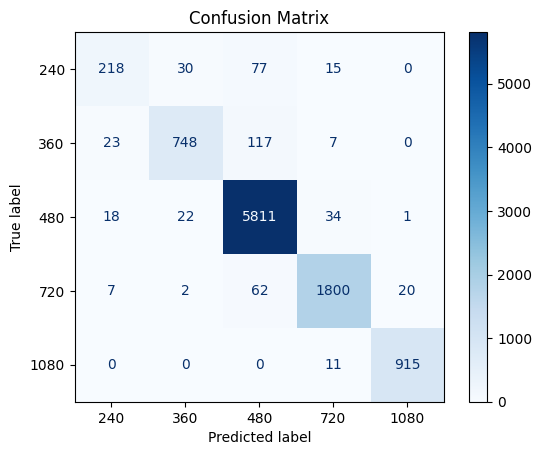

ROC AUC Score (OvR Macro): 0.9945
ROC AUC Score (OvR Weighted): 0.9957



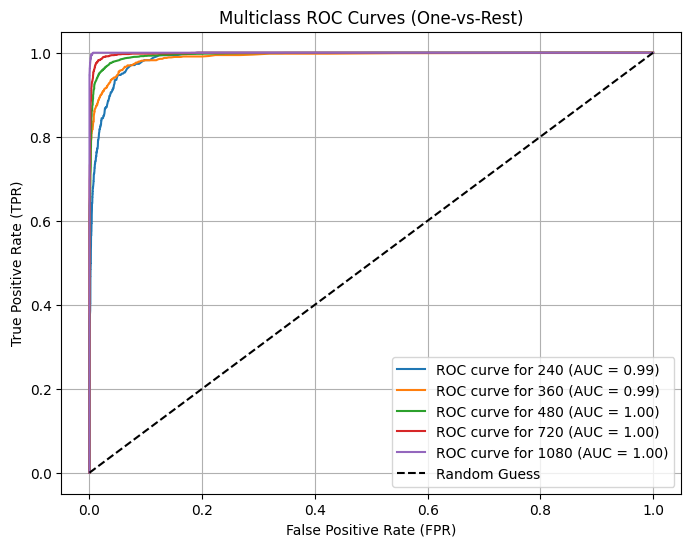

In [20]:
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)

classes = [240, 360, 480, 720, 1080]
class_names = ["240p", "360p", "480p", "720p", "1080p"]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {acc:.4f}\n")


# Classification Report
# This report includes Precision, Recall, and F1 for each class
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Averaged F1 Scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}\n")


# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# For a better visualization:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Get the multiclass one-versus-rest AUC score (averaged)
auc_ovr_macro = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
auc_ovr_weighted = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"ROC AUC Score (OvR Macro): {auc_ovr_macro:.4f}")
print(f"ROC AUC Score (OvR Weighted): {auc_ovr_weighted:.4f}\n")

# Plot the ROC curves for every class vs all other classes
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Calculate ROC curve for class i vs. all other classes
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_proba[:, i])
    
    # Plot the curve
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the "random guess" line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multiclass ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Wow, look how good the ROC curves are! They look just like the ideal ones we saw in class!

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.

Error Rate: 3/60=0.05


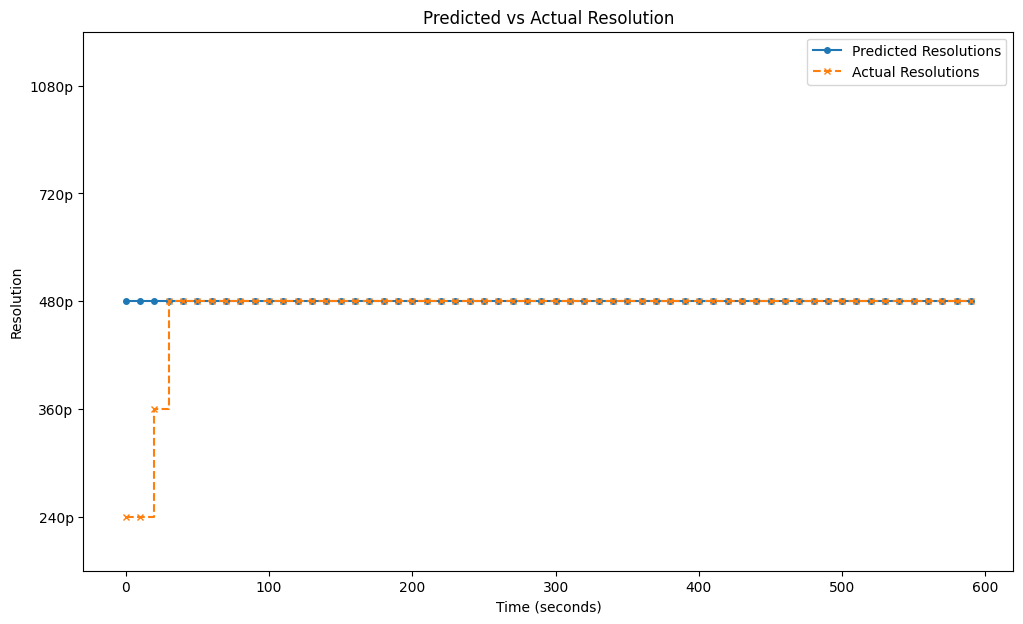

In [21]:
pred_resolutions = best_rf_model.predict(X_session)
actual_resolutions = y_session

num_errors = np.sum((pred_resolutions - actual_resolutions) != 0)
num_timestamps = actual_resolutions.shape[0]
print(f"Error Rate: {num_errors}/{num_timestamps}={num_errors/num_timestamps}" )

y_tick_positions = np.arange(len(classes))
pred_resolutions_map = np.searchsorted(classes, pred_resolutions)
actual_resolutions_map = np.searchsorted(classes, actual_resolutions)

plt.figure(figsize=(12, 7))

# The code below when uncommented will insert x-axis ticks every 10 seconds
# as the problem asks.
# However, the data already appears at 10-second intervals and these lables
# would overlap if enabled. Because of this, I am choosing to leave the ticks
# at the default intervals with the understanding that this is still a plot of
# the data sampled at 10-second intervals.
# =============================================================================
# min_time = np.floor(session_timestamps.min())
# max_time = np.ceil(session_timestamps.max())
# x_tick_positions = np.arange(min_time, max_time + 1, 10)
# plt.xticks(x_tick_positions)
# =============================================================================

# Plot the y values
plt.plot(session_timestamps, pred_resolutions_map, 
         label='Predicted Resolutions', 
         drawstyle='steps-post', 
         marker='o', 
         markersize=4, 
         linestyle='-')
plt.plot(session_timestamps, actual_resolutions_map, 
         label='Actual Resolutions', 
         drawstyle='steps-post', 
         marker='x', 
         markersize=5, 
         linestyle='--')

# Position and label the y-axis ticks
plt.yticks(y_tick_positions, class_names)
plt.ylim(y_tick_positions.min() - 0.5,  y_tick_positions.max() + 0.5)

# Label the graph
plt.title('Predicted vs Actual Resolution')
plt.xlabel('Time (seconds)')
plt.ylabel('Resolution')
plt.legend()

# Display the graph
plt.show()
